# Example - Normal Estimation

The following cell imports the resources needed for basic geometry processing and 3D visualisation. Few resources are referenced to test the implemented algorithm.

In [15]:
import sys,os

# Path to Resources and Python Libraries
RES_PATH = '../../resources'
LIB_PATH = '../../python_lib'

# Checking if the path is found locally
if not os.path.exists(RES_PATH):
    print( 'cannot find \COMPM080-Tutorials-2020\resources\, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# Loading Geo Tools
sys.path.append(LIB_PATH) 
from geo_tools import rd_helper

# Loading libraries for visualisation
import pyglet
pyglet.options['shadow_window'] = False
import pyrender
import matplotlib
import matplotlib.pyplot as plt

# Loading libraries for basic geometry processing
import trimesh
import numpy as np
from sklearn.neighbors import KDTree

found resources


We load the mesh of a torus and sample 30000 points on the surface of the loaded mesh.

In [16]:
# Loading the mesh
mesh_fp = os.path.join(RES_PATH,'torus.obj')
assert os.path.exists(mesh_fp), 'Cannot find:' + mesh_fp 
mm = trimesh.load(mesh_fp)
# Sampling points on the surface of the mesh - looks better with more points, but can be slow
surface_points = mm.sample(3000)
print(surface_points.shape)

(3000, 3)


We can visualise the 3D point cloud sampled in the previous cell.

d:\Anaconda\envs\geo_tutorials\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


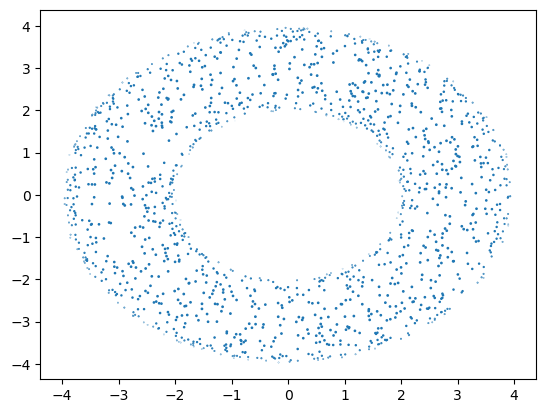

In [17]:
plt.scatter(surface_points[:,0],surface_points[:,1],surface_points[:,2])

# Least square based Normal Estimation

The following cell implements the least square plane fitting for normal estimation.

In [18]:
import numpy.linalg as la

def lstsq_plane_fitting(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours

    num_points, _ = surface_points.shape
    tree = KDTree(surface_points)
    _, indices = tree.query(surface_points, k)
    normals = np.zeros([num_points,3])
    for point in range(num_points):
        neighbours = surface_points[indices[point],:]
        (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]))
        normal = (a, b, c)
        nn = np.linalg.norm(normal)
        normal = normal / nn
        normals[point,:]= normal

    
    return normals

In [19]:
normals = lstsq_plane_fitting(surface_points, 3)

C:\Users\Rob\AppData\Local\Temp\ipykernel_5340\3264557443.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]))


We add a function that helps for visualisation purpose to render the point normals.

In [20]:
def create_vertex_normal_render_obj(surface_points, normals):
    p0 = surface_points
    p1 = surface_points + normals
    edges_mesh = rd_helper.create_edges(p0,p1,no_vex=True)
    return edges_mesh

We can create the scene witht the mesh and the point normals.

In [21]:
# Creation of the objects to render
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)

# Adding the objects into the scene graph

scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))
mesh_node = scene.add(mobj)
if vobj is not None:
    nv_node = scene.add(vobj)

# Initialisation of the context object
gctx={}
gctx['nv_node'] = nv_node
gctx['show_mesh_node'] = True
gctx['show_nv_node'] = True
gctx['scene'] = scene
gctx['cur_scale'] = 1.0
gctx['cur_color'] = np.array((0,255,0), dtype=np.uint8)

In [22]:
def run_gui(scene):        
    v = pyrender.Viewer(scene, use_raymond_lighting=True)
    del v

    
run_gui(scene)

# PCA based normal estimation

The following cell implements the least square plane fitting for normal estimation.

In [9]:
def PCA_normal_estimation(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours

    # You can also use this code to estimate curvatures. But it isn't needed for the normals calculation.

    num_points, _ = surface_points.shape
    tree = KDTree(surface_points)
    _, indices = tree.query(surface_points, k)
    normals = np.zeros([num_points,3])
    curvatures = np.zeros(num_points)
    for point in range(num_points):
        neighbours = surface_points[indices[point],:]
        mean = np.mean(neighbours,axis=0)
        neighbours_adjust = neighbours - mean
        covariance_matrix = np.cov(neighbours_adjust.T)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        sorted_values = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[sorted_values]
        curvature = abs(eigenvalues[2]) / (abs(eigenvalues[0])+abs(eigenvalues[1])+abs(eigenvalues[2]))
        curvatures[point] = curvature
        eigenvectors = eigenvectors[:,sorted_values]
        normal = eigenvectors[:,2]
        nn = np.linalg.norm(normal)
        normal = normal / nn
        normals[point,:] = normal
    
    return normals

In [10]:
normals = PCA_normal_estimation(surface_points, 20)

In [11]:
# Creation of the objects to render
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)

# Adding the objects into the scene graph
scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))
mesh_node = scene.add(mobj)
if vobj is not None:
    nv_node = scene.add(vobj)

# Initialisation of the context object
gctx={}
gctx['nv_node'] = nv_node
gctx['show_mesh_node'] = True
gctx['show_nv_node'] = True
gctx['scene'] = scene
gctx['cur_scale'] = 1.0
gctx['cur_color'] = np.array((0,255,0), dtype=np.uint8)

In [13]:
def run_gui(scene):    
    v = pyrender.Viewer(scene, use_raymond_lighting=True)
    del v
run_gui(scene)

To Colour Based On Normals

In [13]:
pcd_rdobj = pyrender.Mesh.from_points(surface_points, colors=np.abs(normals) ) ### abs makes sure that the RGB values are between 0 and 1.

In [ ]:
def scene_factory(rdobj):
    scene = pyrender.Scene(ambient_light=0.5*np.array([1.0, 1.0, 1.0, 1.0]))
    pcd_nd = scene.add(rdobj)
    
    return scene


def run_gui(rdobj):
    scene = scene_factory(rdobj)
    v=pyrender.Viewer(scene, use_raymond_lighting=True)
    del v


## Run visualisation
### to see it well, you might need to increase number of sampled points.
run_gui(pcd_rdobj)